In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Convolutional Neural Network
### Flower Dataset

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

%matplotlib inline

2024-02-15 00:39:34.170550: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 00:39:42.164812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 00:39:42.165039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 00:39:42.919847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 00:39:44.503504: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')

try:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
except:
    print ('invalid device')

0 Phusical GPUs 0 Logical GPUs


In [3]:
###----------------
### Some parameters
###----------------

inpDir = '/home/dai/Documents/DNN/7.DNN/input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results


EPOCHS = 150 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32
LR_PATIENCE = 10
FACTOR_LR = 0.5
PATIENCE = 20
IMG_HEIGHT = 190
IMG_WIDTH = 190

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [5]:


def fn_plot_label(tr_ds , ts_ds):

    plt.figure(figsize=(15,5)) # instantiate the figure

    plt.subplot(1, 2, 1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis= 0).numpy() # get the lables

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color= 'DarkBlue') # barplot the count

    plt.xticks(range(len(unique)), class_names)

    plt.title('Traning Set')

    plt.subplot(1, 2, 2)

    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis= 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color= 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')

### Using Flowers Data

Coverting to Datasets from a directory

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)

data_dir = pathlib.Path(data_dir)


In [7]:
data_dir

PosixPath('/home/dai/.keras/datasets/flower_photos')

In [5]:
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'roses', 'daisy']

In [6]:
#create traning data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, #path to the data directory
    validation_split = TEST_SIZE, #what ratio of validation data
    subset = 'training', #purpose
    seed = RANDOM_STATE,
    image_size = [IMG_HEIGHT, IMG_WIDTH],
    batch_size = BATCH_SIZE
)

#create test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, #path to the data directory
    validation_split = TEST_SIZE, #what ratio of validation data
    subset = 'validation', #purpose
    seed = RANDOM_STATE,
    image_size = [IMG_HEIGHT, IMG_WIDTH],
    batch_size = BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
train_ds 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 190, 190, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

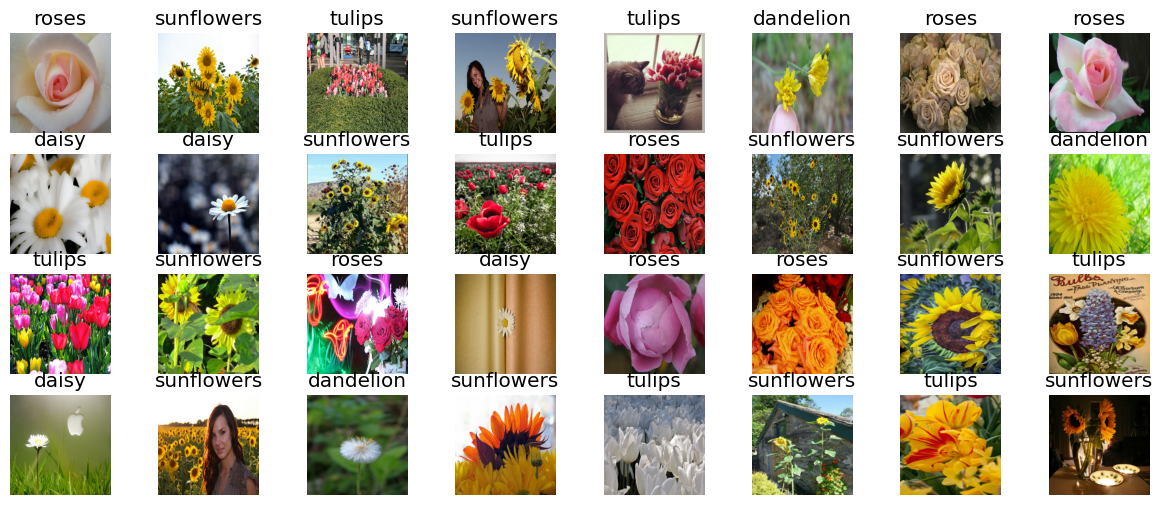

In [11]:
plt.figure(figsize=(15,6))

for images, labels in train_ds.take(1): # get me one batch

    for i in range (BATCH_SIZE): #loop over batch

        plt.subplot(int(BATCH_SIZE/8),8, i+1) # access the axis

        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int

        plt.title(class_names[labels[i]])

        plt.axis('off')

    plt.show()

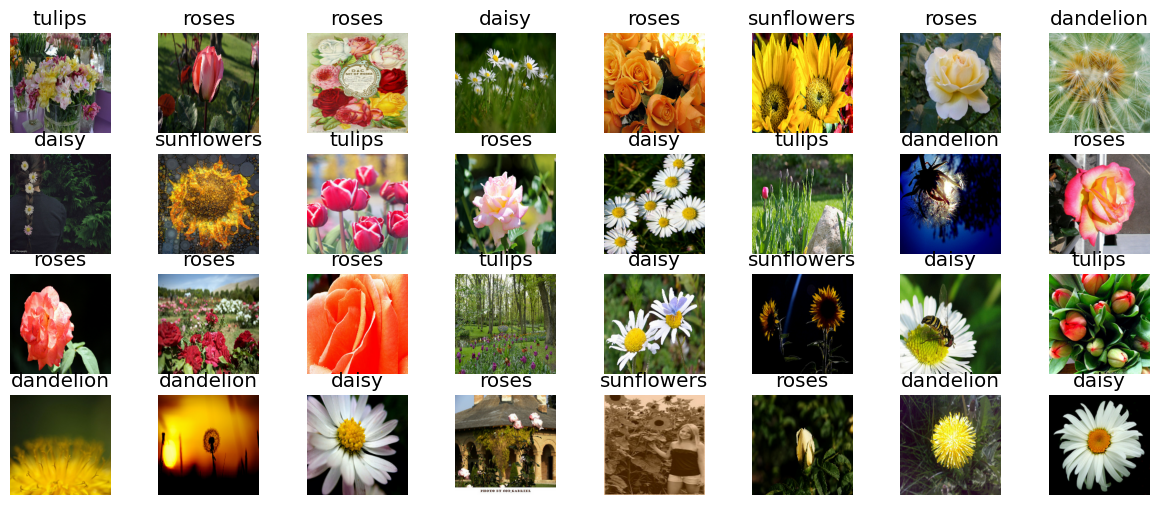

In [12]:
plt.figure(figsize=(15,6))

for images, labels in test_ds.take(1): # get me one batch

    for i in range (BATCH_SIZE): #loop over batch

        plt.subplot(int(BATCH_SIZE/8),8, i+1) # access the axis

        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int

        plt.title(class_names[labels[i]])

        plt.axis('off')

    plt.show()

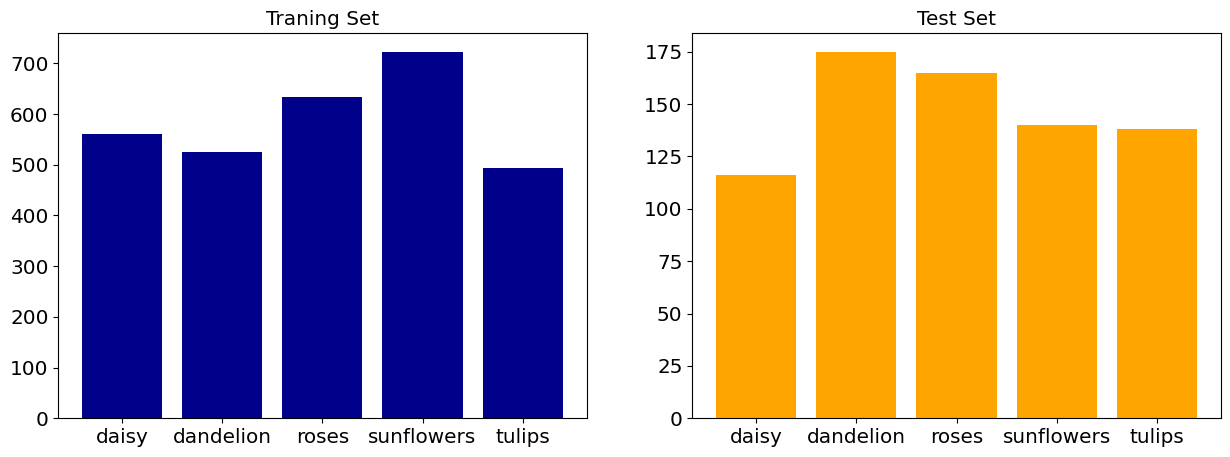

In [13]:
fn_plot_label(train_ds, test_ds)

In [14]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## Random Zoom

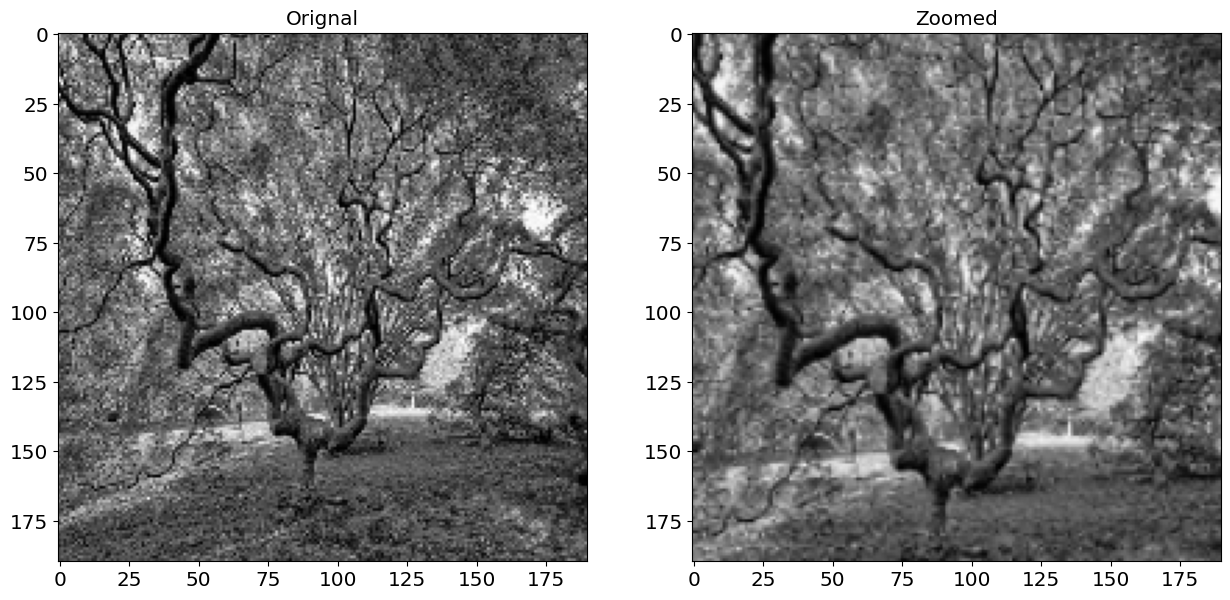

In [15]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2),
                                   width_factor=(-0.2, -0.2))

plt.figure()

img_num = 3

for images, labels in test_ds.take(1): # get me one batch

    out_images = layer(images)

    plt.subplot(1, 2, 1)
    plt.title('Orignal')
    plt.imshow(images[img_num].numpy().astype('uint8'))

    plt.subplot(1, 2, 2)
    plt.title('Zoomed')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))


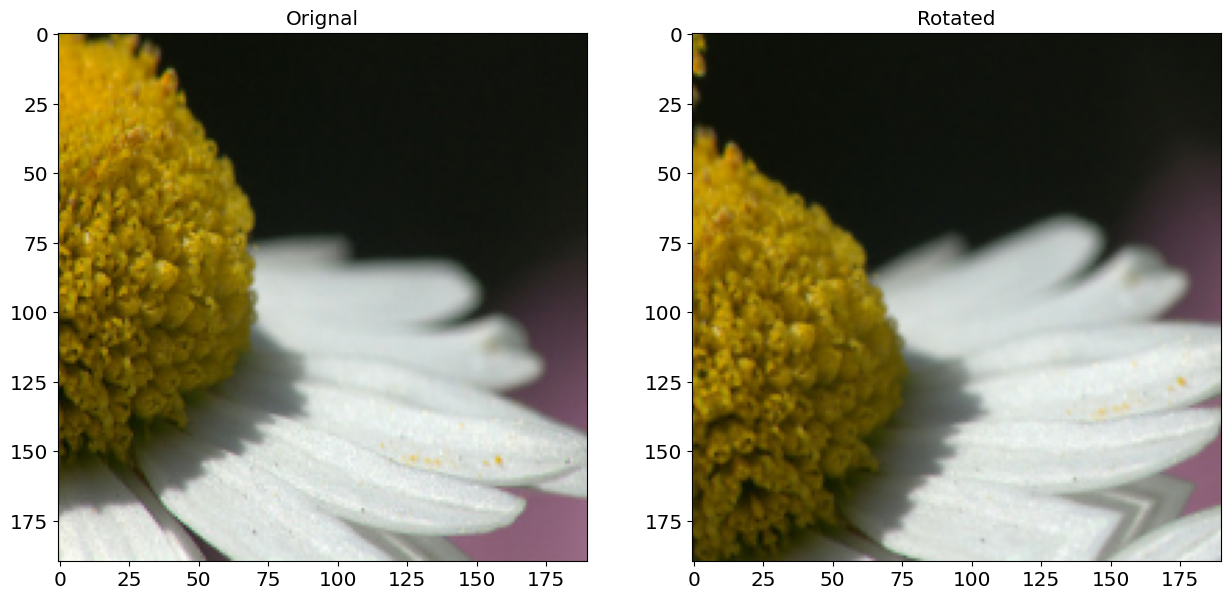

In [16]:
layer = tf.keras.layers.RandomRotation((-0.2, 0.3))

plt.figure()

img_num = 3

for images, labels in test_ds.take(1): # get me one batch

    out_images = layer(images)

    plt.subplot(1, 2, 1)
    plt.title('Orignal')
    plt.imshow(images[img_num].numpy().astype('uint8'))

    plt.subplot(1, 2, 2)
    plt.title('Rotated')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))


In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Build model
dor1 = 0.01
#knl_reg = tf.keras.regularizers.L2(l2 = 0)
model = tf.keras.Sequential()

# model.add(tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2)))



model.add(tf.keras.layers.Rescaling(1/255.)), # Convert between 0 and 1
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation((-0.2, 0.3)))

##-------
### Set 1
###-------
# Conv layer
model.add(tf.keras.layers.Conv2D(8, (3,3))), # 188 x 188 x 8

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
### Pooling
# model.add(tf.keras.layers.MaxPool2D(2, 2)), # 94 x 94 x 8

###-------
### Set 2
###-------
# Conv layer
model.add(tf.keras.layers.Conv2D(16, (3,3))), # 92 x 92 x 16

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
### Pooling
model.add(tf.keras.layers.MaxPool2D(2, 2)), # 46 x 46 x 16

###-------
### Set 3
###-------
# Conv layer
model.add(tf.keras.layers.Conv2D(32, (3,3))), # 44 x 44 x 32

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
### Pooling
model.add(tf.keras.layers.MaxPool2D(2, 2)), # 22 x 22 x 32

###-------
### Set 4
###-------
# Conv layer
model.add(tf.keras.layers.Conv2D(64, (3,3))), # 20 x 20 x 64

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
### Pooling
model.add(tf.keras.layers.MaxPool2D(2, 2)), # 10 x 10 x 64

###-------
### Set 5
###-------
# Conv layer
model.add(tf.keras.layers.Conv2D(128, (3,3))), # 8 x 8 x 128

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
### Pooling
model.add(tf.keras.layers.MaxPool2D(2, 2)), # 4 x 4 x 128

###-------
### Set 6
###-------

model.add(tf.keras.layers.Conv2D(256, (3,3))), # 2 x 2 x 256

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))
###------------
### Head Start
###------------
model.add(tf.keras.layers.Flatten()), # Flatten

model.add(tf.keras.layers.Dense(256)), # Dense 1

# model.add(tf.keras.layers.BatchNormalization()),
model.add(tf.keras.layers.Activation('relu')),

# model.add(tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE))

model.add(tf.keras.layers.Dense(5)) #Output

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    mode = 'auto',
    baseline = None,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto',

)

#define model file path
modelFile = os.path.join(modelDir, subDir, altName)

#define checkpoint callback
model_callback = tf.keras.callbacks.ModelCheckpoint(
    modelFile,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto'
)

In [20]:
optim = tf.keras.optimizers.AdamW(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile(optimizer = optim, loss = loss_fn, metrics = ['accuracy'])

In [21]:
history = model.fit(train_ds, validation_data=test_ds,
                    epochs=EPOCHS, verbose = 1,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, lr_decay, model_callback])

Epoch 1/150
92/92 [==============================] - ETA: 0s - loss: 1.4578 - accuracy: 0.3345
Epoch 1: val_loss improved from inf to 1.39111, saving model to ../models/flower_photos/cnn_base
92/92 [==============================] - 43s 418ms/step - loss: 1.4578 - accuracy: 0.3345 - val_loss: 1.3911 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 2/150
92/92 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.5232
Epoch 2: val_loss improved from 1.39111 to 1.09704, saving model to ../models/flower_photos/cnn_base
92/92 [==============================] - 38s 412ms/step - loss: 1.1410 - accuracy: 0.5232 - val_loss: 1.0970 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 3/150
92/92 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.5838
Epoch 3: val_loss improved from 1.09704 to 0.98254, saving model to ../models/flower_photos/cnn_base
92/92 [==============================] - 33s 353ms/step - loss: 0.9855 - accuracy: 0.5838 - val_loss: 0.9825 - val_accuracy: 0

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 190, 190, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 190, 190, 3)       0         
 otation)                                                        
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 8)       224       
                                                                 
 activation (Activation)     (None, 188, 188, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 186, 186, 16)      1168      
                                                        

In [ ]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

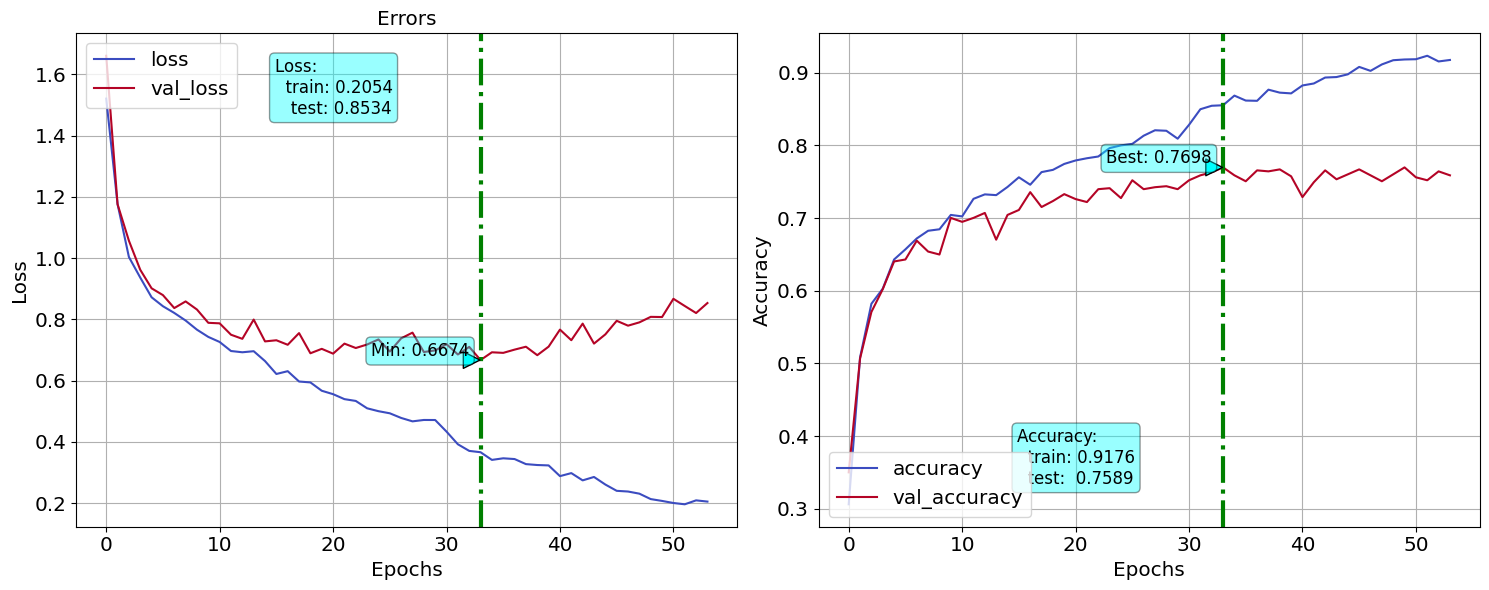

In [ ]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,lr
33,0.366465,0.855245,0.667402,0.769755,0.0005
